---

<h1 style="color:#012eba">Introduction to Image Processing with Python</h1>
<h1 style="color:#012eba">Episode 6: Image Segmentation - Part 2</h1>

---

*DASCI 261 - Introduction to Image Processing*

*Prepared by Erika G. Lacson*

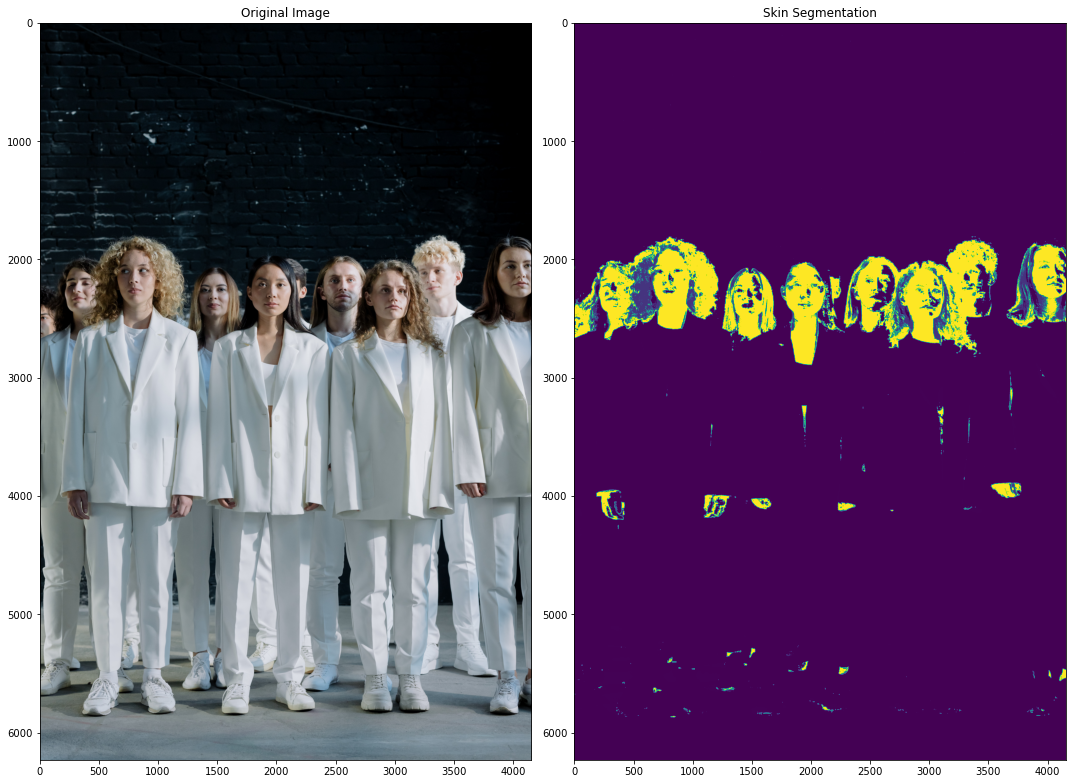

(Left) Photo by cottonbro studio in pexels. | (Right) Image processed by the Author.

---
<h2 style="color:#ff0090">Introduction</h2>

Hello again, my fellow image processing enthusiasts! 🖐️ Welcome to Episode 6, the second part of our deep dive into the world of Image Segmentation! 🌍🔍 In the last episode, we explored thresholding, Otsu’s method, and the fascinating realm of color image segmentation. This time, we’re about to add more colors to our palette with Chromaticity Segmentation and the concept of Image Differencing. 🌈

Ready for an even deeper dive into the heart of image analysis? Buckle up, because we’re taking a vibrant journey through:


- Chromaticity Segmentation 🎨 (This episode)
- Image Differencing 🔄 (This episode)

---
<h2 style="color:#ff0090">Chromaticity Segmentation 🎨</h2>

When it comes to image segmentation, color plays a key role in distinguishing different regions of an image. But have you ever encountered a situation where lighting conditions made color segmentation a nightmare? 💡😱 No worries, Chromaticity Segmentation is here to save your day!

<b>Chromaticity Segmentation</b> normalizes the RGB values of each pixel, making our segmentation independent of lighting conditions. How cool is that? We’ll dive deep into this method, exploring how we can apply it to our images to get more accurate and reliable segmentations.

But, before we start jumping in, let’s discuss the RG Chromaticity space. It’s a two-dimensional representation of color that removes intensity values from our colors. It’s all about the proportion of the difference in color channels, mapping it in the normalized RGB space. 🗺️🔴💚

Excited? Let’s take this journey step-by-step!

To compute for the RG Chromaticity of an image, we use the following equations:

<img src="eq.png" alt="equations" width="200"/>

Image by Borja, B.

To illustrate:
<img src="rg_chrom.png" alt="RG-Chromaticity" width="400"/>

Image by Borja, B.


This plot shows us the different colors plotted in the RG color space. Notice that we are just plotting the R and G colors, why is this the case?

Because we can compute for b just by using 1-r-g.

Let's try segmenting our plants image using this. But first, let's import the necessary libraries:

In [1]:
# Import the necessary libraries
from skimage.io import imread, imshow
import matplotlib.colors as colors
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
import numpy as np

We can use RG Chromaticity in both Parametric or Non-Parametric Segmentation.

---
<h3 style="color:#9e02bb">Parametric Segmentation</h3>


The good thing about this type of segmentation combined with RG Chromaticity is that we can mask any shape.

So let's test it out. We first need to compute for the RG Chromaticity of our image:

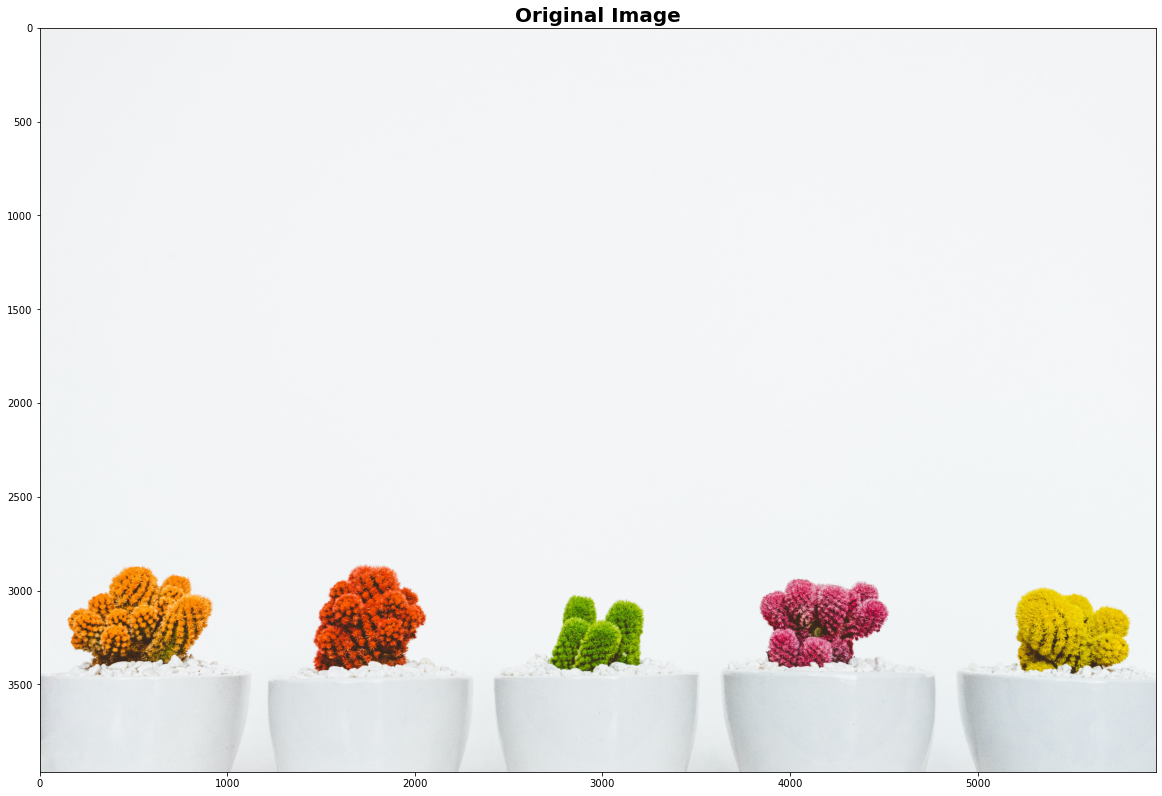

In [2]:
# Display the original image
original_image = imread('plants.jpg')
plt.figure(figsize=(20,20))
plt.imshow(original_image)
plt.title('Original Image', fontsize=20, weight='bold')
plt.show()

Photo by Scott Webb on Unsplash

We use our equations to compute for the RG Chromaticity: 

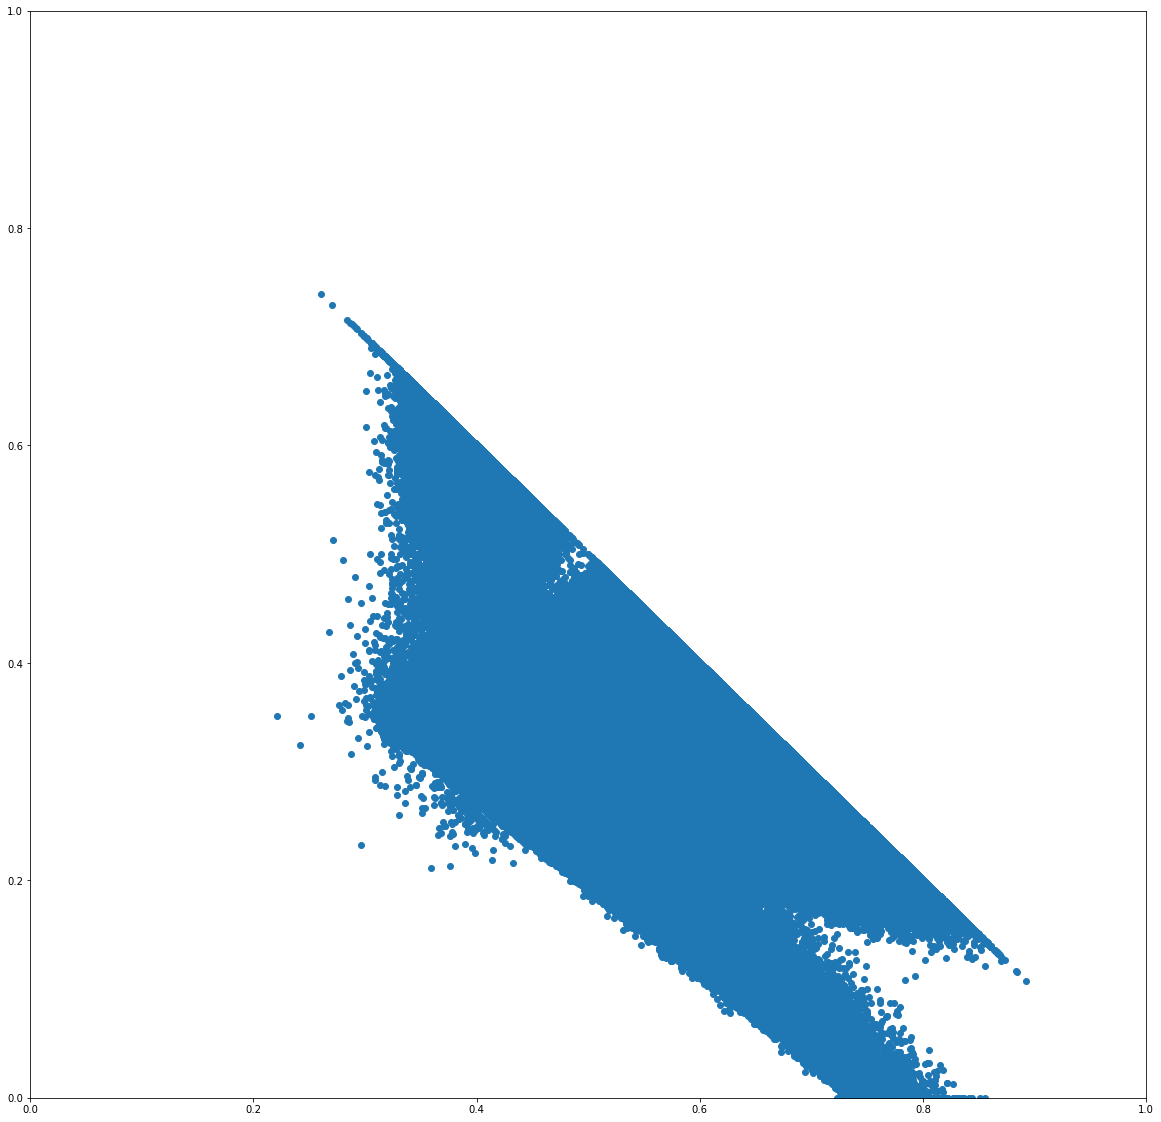

In [3]:
original_image_R = original_image[:,:,0]*1.0/original_image.sum(axis=2)
original_image_G = original_image[:,:,1]*1.0/original_image.sum(axis=2)

plt.figure(figsize=(20,20))
plt.scatter(original_image_R.flatten(),original_image_G.flatten())
plt.xlim(0,1)
plt.ylim(0,1);

Photo by Author.

We can compute for the 2D histogram of the color values by:

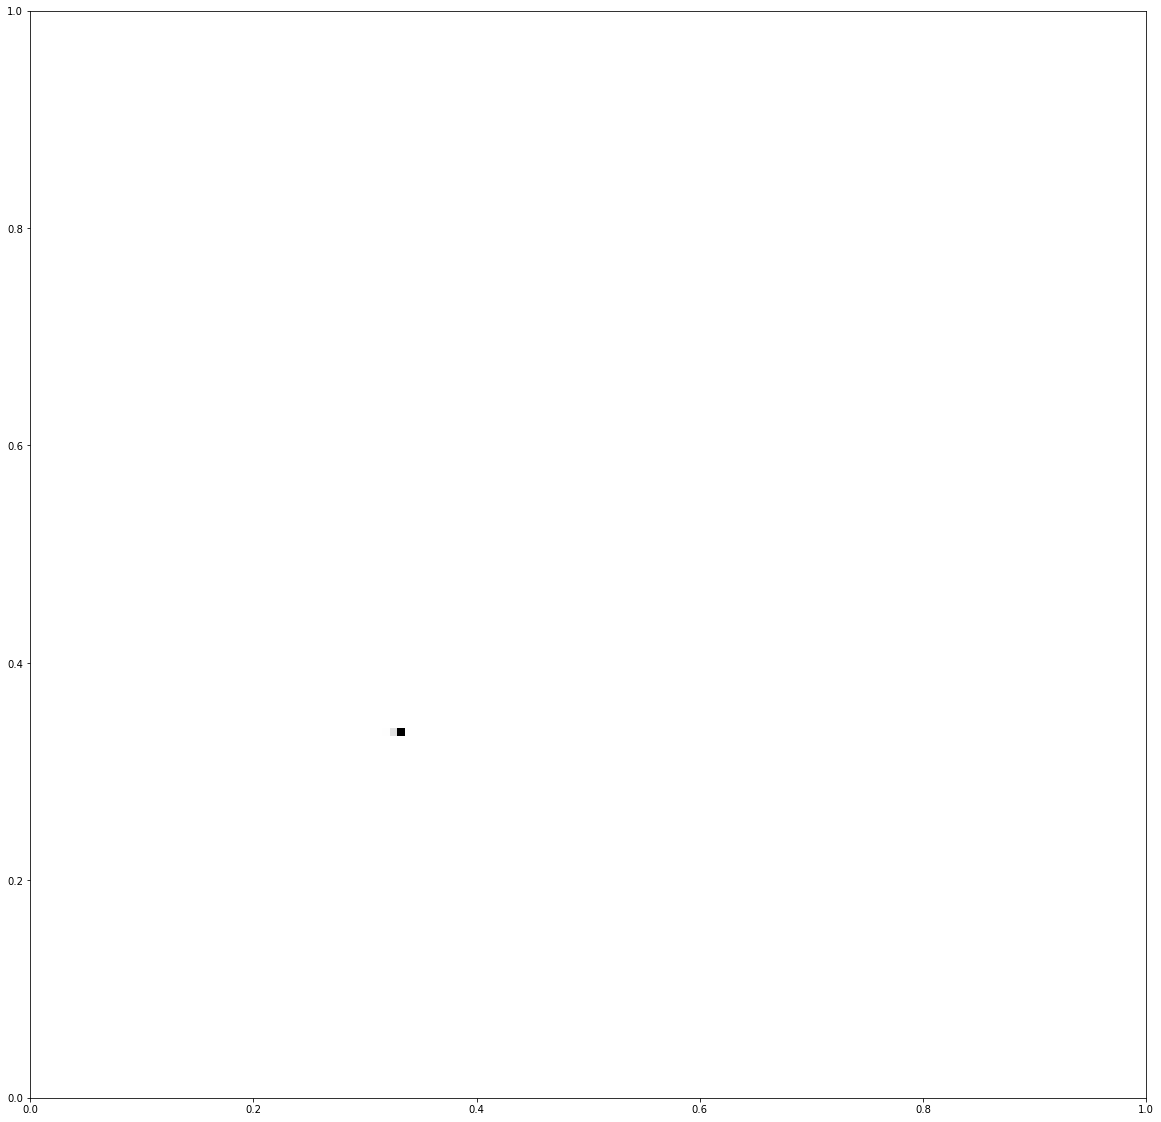

In [4]:
plt.figure(figsize=(20,20))
plt.hist2d(original_image_R.flatten(), 
           original_image_G.flatten(), 
           bins=100,cmap='binary')
plt.xlim(0,1)
plt.ylim(0,1);

Photo by Author.

From here, we would notice what color or group of colors comprises our image. To segment our image, we would need to find a reference patch and take the RG Chromaticity of that reference image. Let’s consider the following green patch:

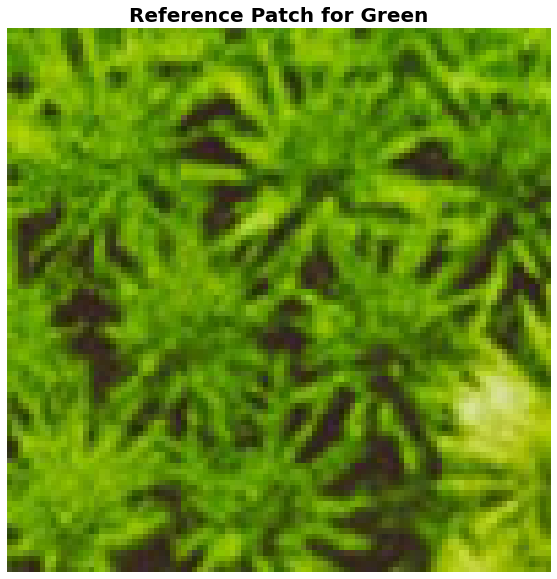

In [8]:
patch = original_image[3200:3300,2800:2900,:]
plt.figure(figsize=(10,10))
plt.imshow(patch)
plt.title('Reference Patch for Green', fontsize=20, weight='bold')
plt.axis('off');

Photo by Author.

Getting the RG Chromaticity of this patch:

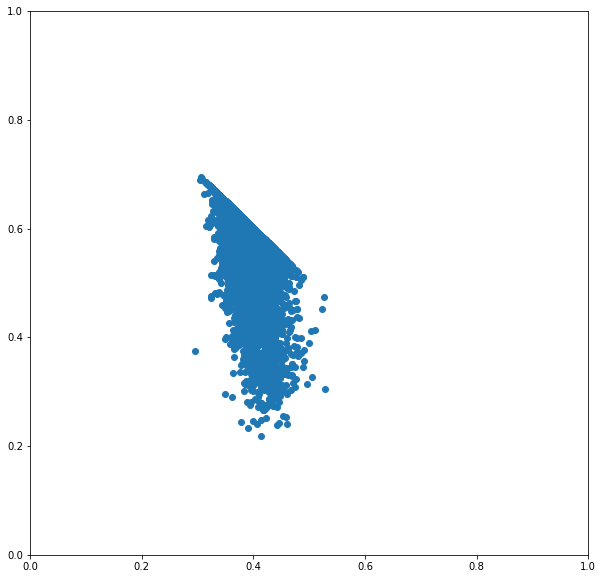

In [12]:
patch_R = patch[:,:,0]*1.0/patch.sum(axis=2)
patch_G = patch[:,:,1]*1.0/patch.sum(axis=2)

plt.figure(figsize=(10,10))
plt.scatter(patch_R.flatten(),patch_G.flatten())
plt.xlim(0,1)
plt.ylim(0,1);

Photo by Author.

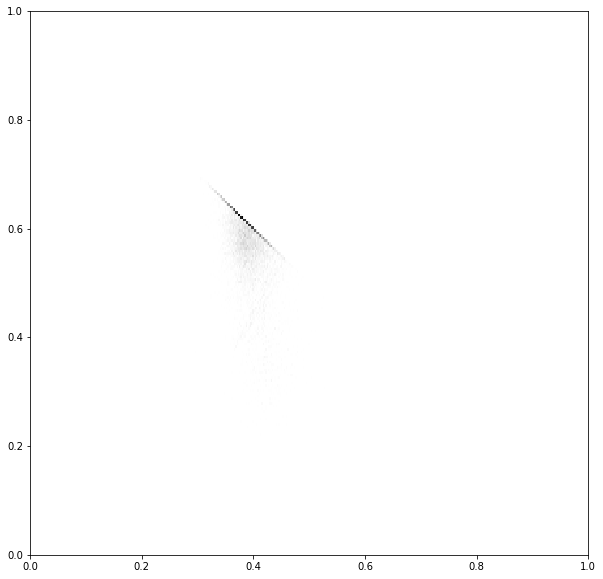

In [13]:
plt.figure(figsize=(10,10))
plt.hist2d(patch_R.flatten(), patch_G.flatten(), bins=100,cmap='binary')
plt.xlim(0,1)
plt.ylim(0,1);

Photo by Author.

**Parametric segmentation** now requires us to fit a gaussian probability distribution using this mask. This probability distribution would dictate which pixel belongs to the color of interest. To do this, we need to compute for the Mean and Standard Deviation of our object of interest.

In [14]:
std_patch_R = np.std(patch_R.flatten())
mean_patch_R = np.mean(patch_R.flatten())

std_patch_G = np.std(patch_G.flatten())
mean_patch_G = np.mean(patch_G.flatten())

Then, defining our Gaussian Function:

In [15]:
def gaussian(p,mean,std):
    return np.exp(-(p-mean)**2/(2*std**2))*(1/(std*((2*np.pi)**0.5)))

Trying this out with our computed values:

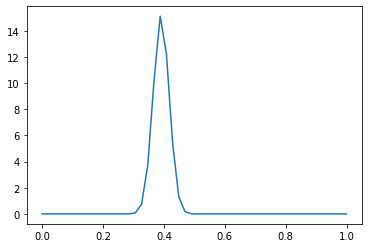

In [16]:
x = np.linspace(0,1)
y = gaussian(x,mean_patch_R,std_patch_R)
plt.plot(x,y);

This distribution gives us the probability of a color being part of our image using the R coordinate. We can actually mask our image just by using this:

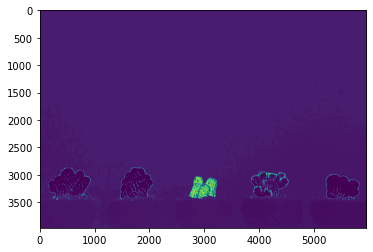

In [22]:
prob_R = gaussian(original_image_R,mean_patch_R,std_patch_R)
plt.imshow(prob_R);

But this covers a *band* in our RG space. We also need to apply the G distribution.

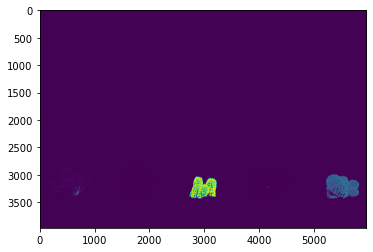

In [23]:
prob_G = gaussian(original_image_G,mean_patch_G,std_patch_G)
plt.imshow(prob_G);

And since we're considering independent probabilities, we can simply multiply the masks together:

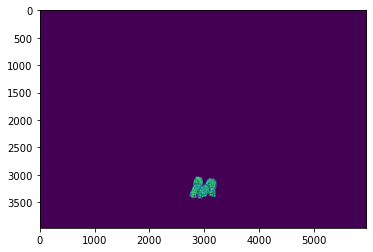

In [24]:
prob=prob_R * prob_G
plt.imshow(prob)

This now gives us the probability of the color being part of our reference patch. And that's it, we found another way to segment our image using parametric segmentation!

---
<h3 style="color:#9e02bb">Non - Parametric Segmentation</h3>

For cases where our region of interest cannot be approximated by a 2D Gaussian function, we can use a non-paramentric segmentation method. For this, we would use the 2D Histogram of our reference image and use histogram backprojection to mask our original image with the computed histogram of our reference patch.

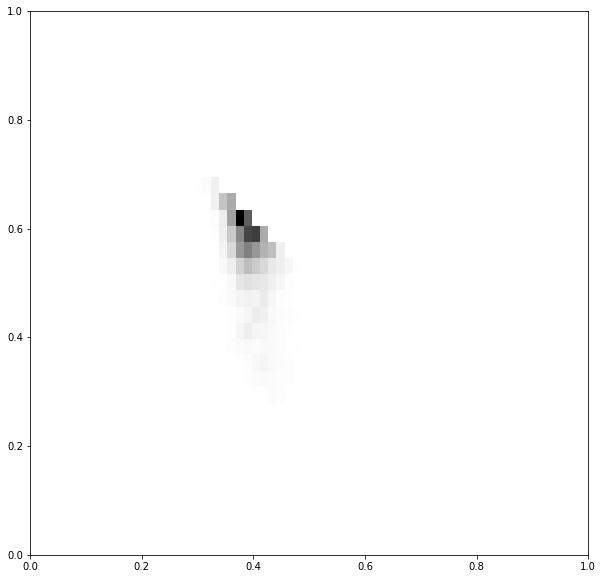

In [26]:
plt.figure(figsize=(10,10))
plt.hist2d(patch_R.flatten(), patch_G.flatten(), bins=16,cmap='binary')
plt.xlim(0,1)
plt.ylim(0,1);

Photo by Author.

To do this, we use histogram back-projection in which we give each pixel location a value equal to it’s histogram value in chromaticity space.

#### Let's test this knowledge:

The non-parametric segmentation is especially usefull for multi-color segmentation. Create a collage of different skin patch samples then create a segmentation model by implementing the backprojection algorithm.

In [46]:
def backproj(patch, image):
    # Convert both images to the HSV color space
    patch_hsv = colors.rgb_to_hsv(patch)
    image_hsv = colors.rgb_to_hsv(image)

    # Compute the 2D histogram of the reference patch in the H and S channels
    patch_hist, x_edges, y_edges = np.histogram2d(
        patch_hsv[:, :, 0].flatten(), patch_hsv[:, :, 1].flatten(), bins=(6, 2) , range=[[0, 1], [0, 1]])

    # Normalize the histogram to have a maximum value of 1
    patch_hist = patch_hist / np.max(patch_hist)

    # Compute the backprojection of the image histogram using the reference patch histogram
    indices_h = np.searchsorted(x_edges, image_hsv[:, :, 0], side='left') - 1
    indices_s = np.searchsorted(y_edges, image_hsv[:, :, 1], side='left') - 1
    backproj = patch_hist[indices_h, indices_s]

    # Normalize the backprojection to have a maximum value of 1
    backproj = backproj / np.max(backproj)
    
    # Display the original image and the backprojection side by side
    plt.figure(figsize=(15, 15))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title('Original Image')
    plt.subplot(1, 2, 2)
    plt.imshow(backproj)
    plt.title('Skin Segmentation')
    plt.tight_layout()
    plt.show()

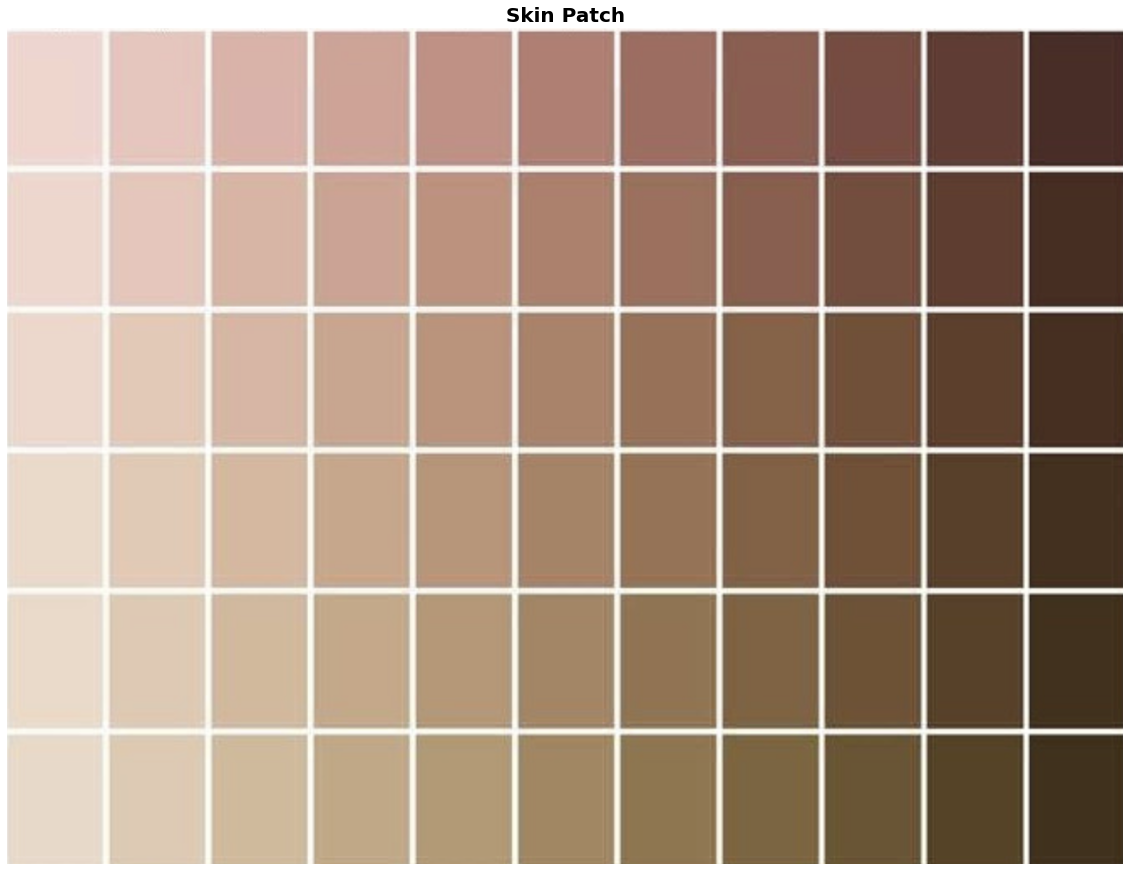

In [30]:
patch = imread('patch.png')[:,:,:3]
plt.figure(figsize=(20,20))
plt.imshow(patch)
plt.title('Skin Patch', fontsize=20, weight='bold')
plt.axis('off');

L’Oréal skin color chart (https://www.loreal.com/en/articles/science-and-technology/expert-inskin/)

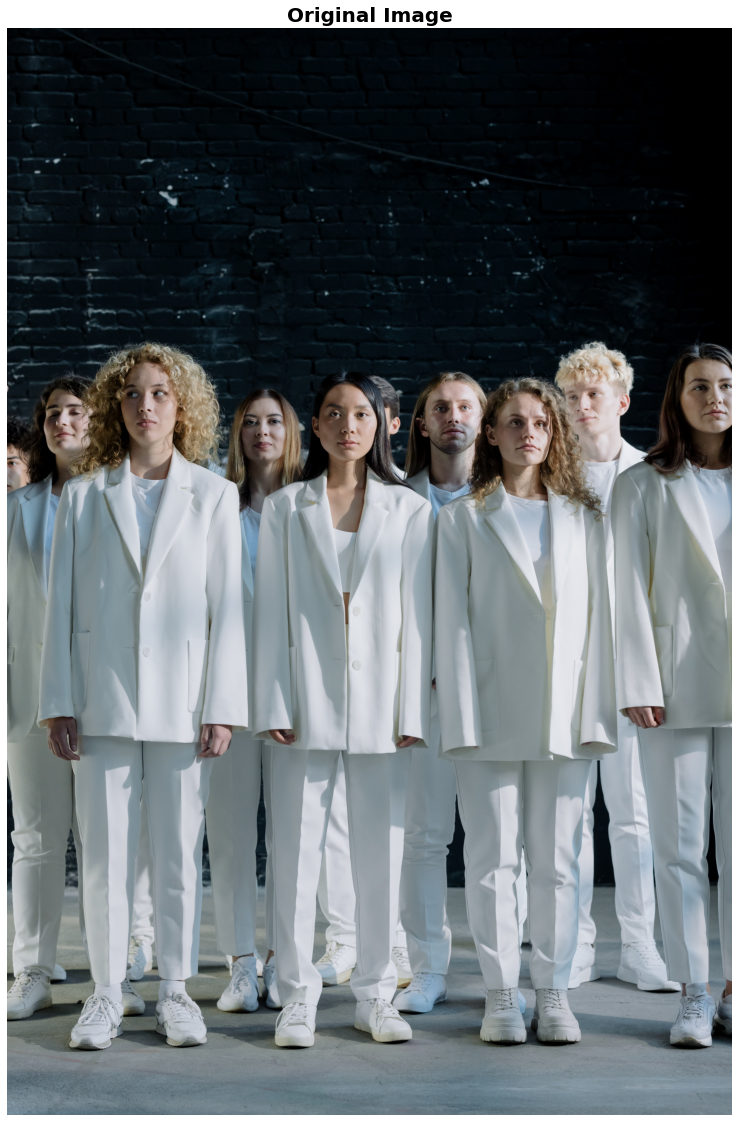

In [31]:
image = imread('people.jpg')[:,:,:3]
plt.figure(figsize=(20,20))
plt.imshow(image)
plt.title('Original Image', fontsize=20, weight='bold')
plt.axis('off');

Photo by cottonbro studio in pexels

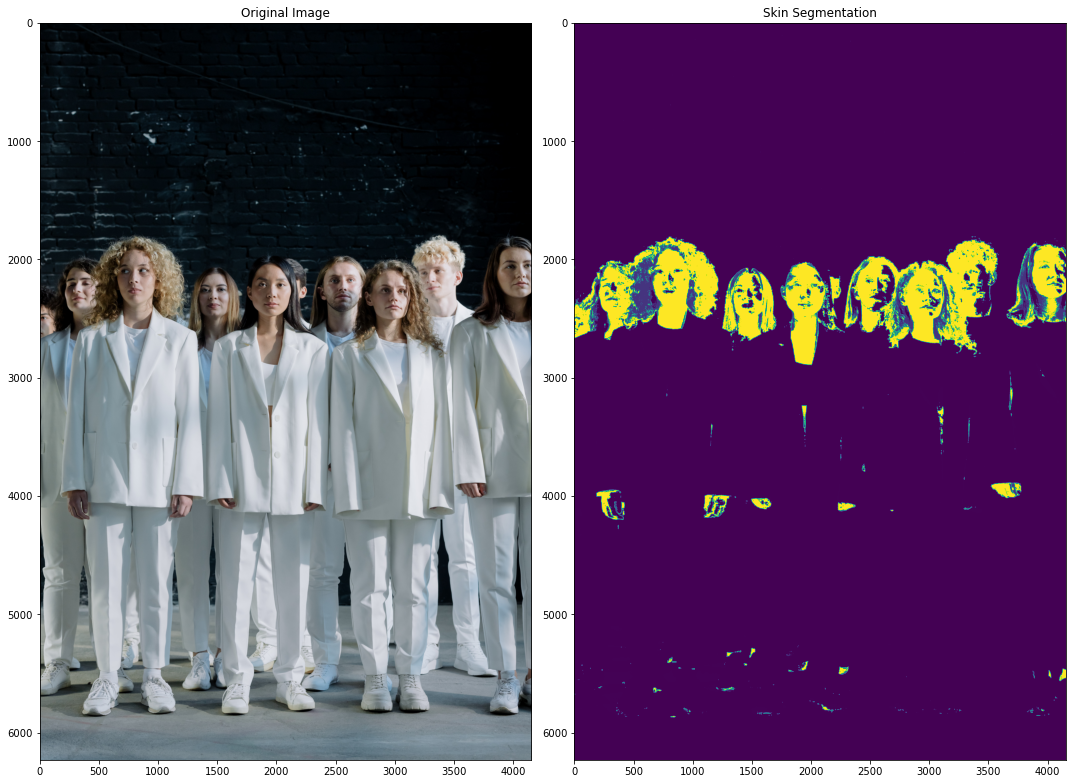

In [47]:
# Call the backproj function to compute the backprojection of the image
backproj(patch, image)

(Left) Photo by cottonbro studio in pexels. | (Right) Skin Segmented from the original image.

Well done!

---
<h2 style="color:#ff0090">Image differencing🎨</h2>

Ever wondered how to detect changes or movements in your videos or images? Instead of segmenting by color for our regions of interest, we can instead look at the difference between two images to find our objects.

Yes, you heard it right! Image Differencing is another awesome tool that allows us to capture dynamic changes over time. 🕐⏳

In this part of the episode, we’ll demonstrate how we successfully identified the missing item from our image using Image Differencing. It’s like playing a digital version of the classic game “Spot the Difference”! 🧐🔍

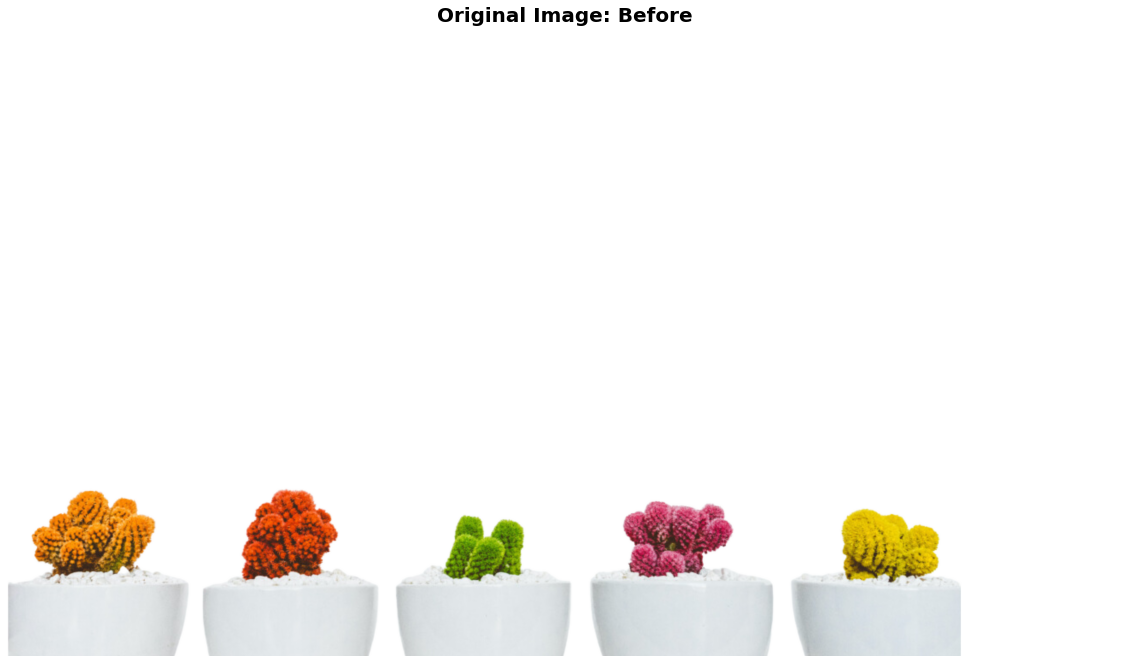

In [39]:
image1 = imread('before.png')
plt.figure(figsize=(20,20))
plt.imshow(image1)
plt.title('Original Image: Before', fontsize=20, weight='bold')
plt.axis('off');

Photo by Scott Webb on Unsplash

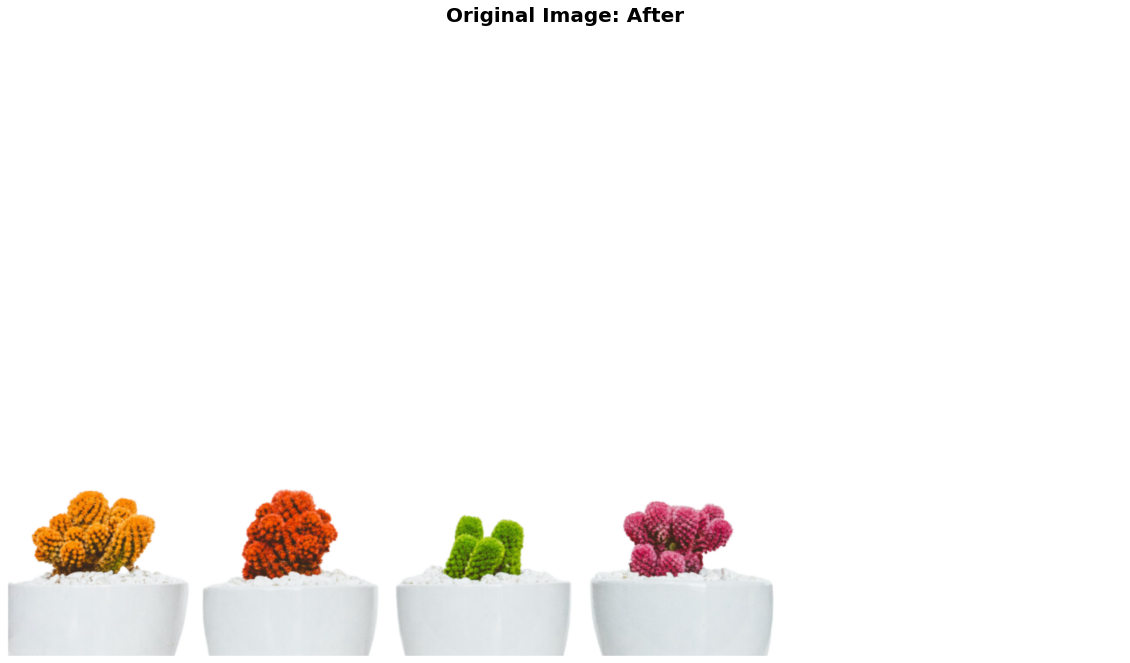

In [40]:
image2 = imread('after.png')
plt.figure(figsize=(20,20))
plt.imshow(image2)
plt.title('Original Image: After', fontsize=20, weight='bold')
plt.axis('off');

Photo by Scott Webb on Unsplash, processed by author.

Notice what’s missing? It’s easy to identify now, but what if you’re working on multiple images or videos. So that’s where Image Differencing shines. But before we do that, let’s convert the images to grayscale as it works better on grayscale images:



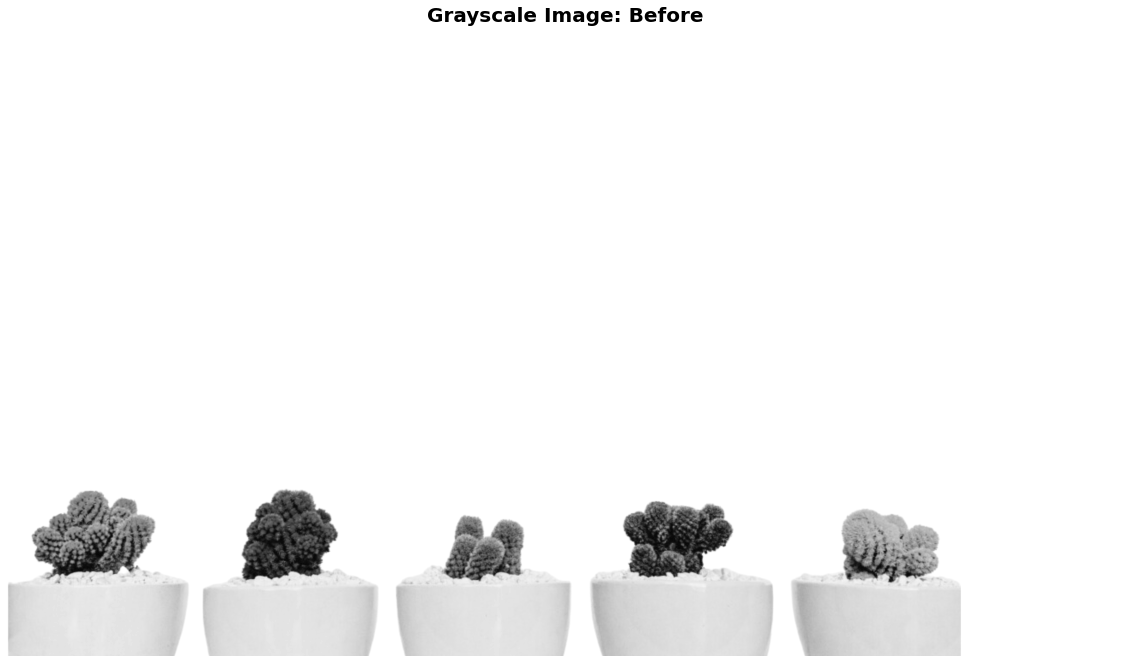

In [41]:
image1_gray = rgb2gray(image1[:,:,:3])
plt.figure(figsize=(20,20))
plt.imshow(image1_gray, cmap='gray')
plt.title('Grayscale Image: Before', fontsize=20, weight='bold')
plt.axis('off');

Photo by Scott Webb on Unsplash, processed by Author.


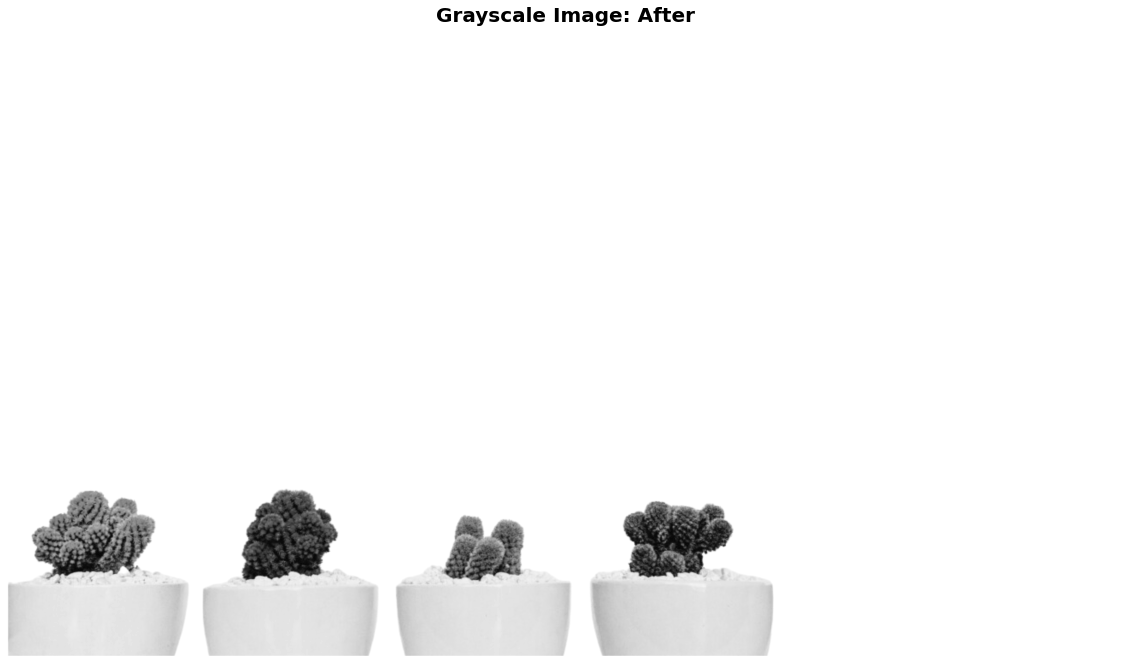

In [42]:
image2_gray = rgb2gray(image2[:,:,:3])
plt.figure(figsize=(20,20))
plt.imshow(image2_gray, cmap='gray')
plt.title('Grayscale Image: After', fontsize=20, weight='bold')
plt.axis('off');

Photo by Scott Webb on Unsplash, processed by Author.


Now, let’s perform image differencing. It’s simply a subtraction between 2 images:

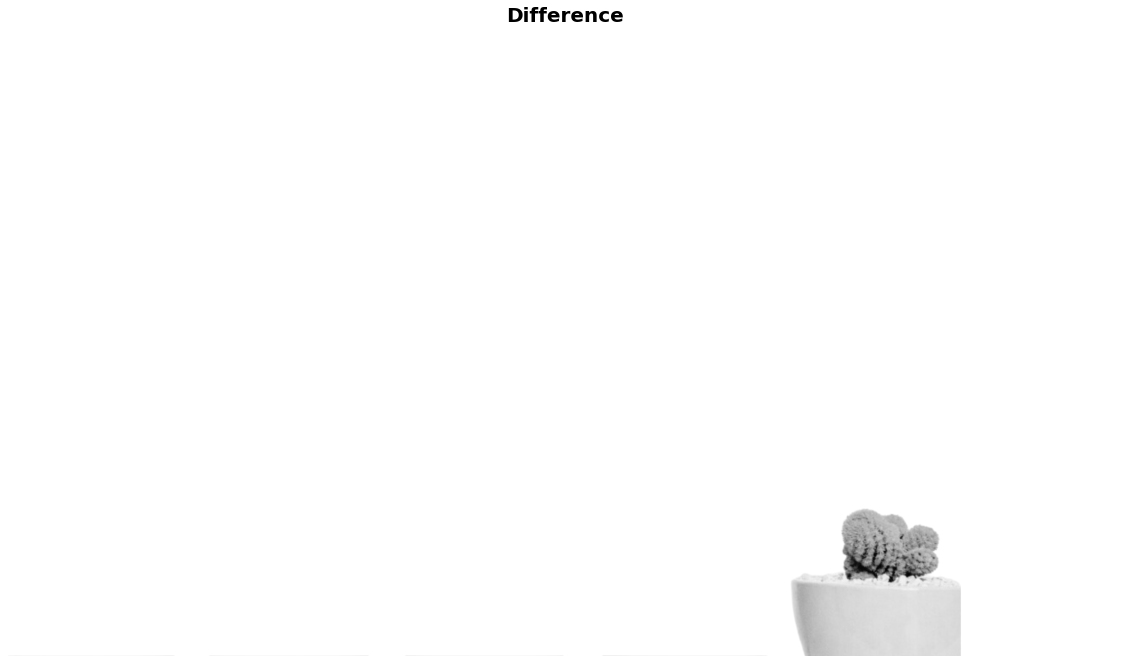

In [43]:
diff = image1_gray - image2_gray
plt.figure(figsize=(20,20))
plt.imshow(diff, cmap='gray')
plt.title('Difference', fontsize=20, weight='bold')
plt.axis('off');

Photo by Scott Webb on Unsplash, processed by Author.

Of course, it’s the last plant. But let’s look at that in colored version:

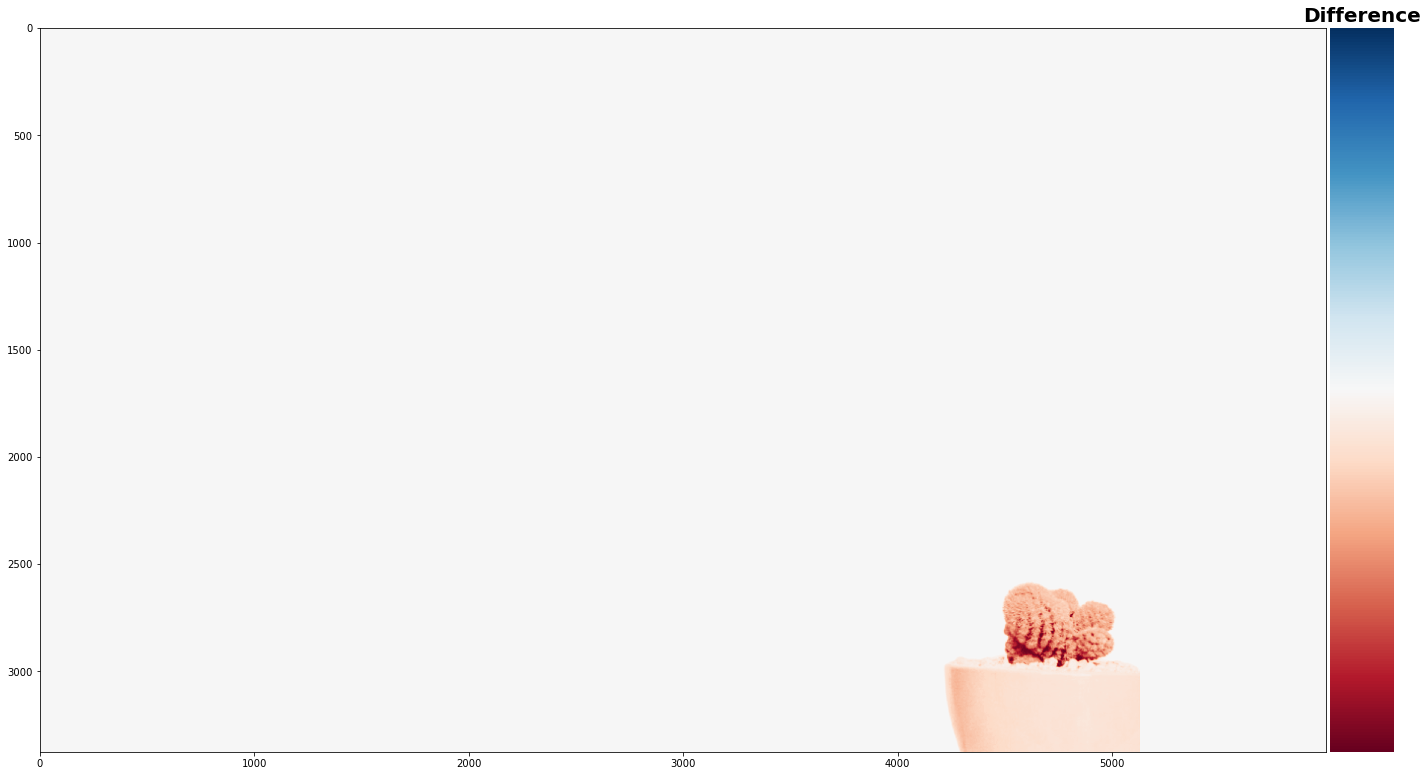

In [45]:
diff = image1_gray - image2_gray
plt.figure(figsize=(20,20))
imshow(diff)
plt.title('Difference', fontsize=20, weight='bold')
plt.axis('off');

Photo by Scott Webb on Unsplash, processed by Author.

---
<h2 style="color:#ff0090">Conclusion 🏁</h2>

Wow! What an exciting journey it’s been! We ventured deeper into the vibrant realm of Chromaticity Segmentation, learning to normalize our RGB values and accurately segment our `people` images with different skin colors. 🌈💡

We also explored the dynamic world of Image Differencing, learning to capture changes over time and detect movements in our videos or images. 🔄🎞️

As we wrap up this episode, remember, my fellow image processing enthusiasts, these techniques are just tools in your toolbox. It’s the problem you’re trying to solve and the creativity you bring that really makes the magic happen! 🧙‍♂️✨

Stay curious, keep learning, and never stop exploring the world of pixels. Because every pixel has a tale to tell, and you, my friend, are the storyteller. 🎨📖

Until next time, keep coding, keep exploring, and most importantly, have fun! See you in the next episode! 🚀👩‍💻👨‍💻🌟

---
<h2 style="color:#ff0090">References</h2>


Borja, B. (2023). Lecture 6: Image Segmentation Part 2 [Jupyter Notebook]. Introduction to Image Processing 2023, Asian Institute of Management.